# Plasmid heterozygosis: single-cell microfluidics data analysis

## Mounting gDrive


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Setup system

In [0]:
!pip install ipyparallel

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import sys
import pathlib
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import scipy.stats as st
from scipy.stats import linregress
from IPython.display import HTML, display
import csv
import pandas as pd

from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('pdf', 'png')
#plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

#plt.rcParams['text.usetex'] = True
#plt.rcParams['font.family'] = "serif"
#plt.rcParams['font.serif'] = "cm"
#plt.rcParams['text.latex.preamble']="\\usepackage{subdepth},\\usepackage{type1cm}"

print("> Python libraries imported")

> Python libraries imported


In [0]:
#sys.path.insert(0, '/Users/ESB/RPM_SYNC/RPM_Work/uJ_master/current/uJ_src/python/')
#sys.path.insert(0, '/home/esb/Projects/uJ/uJ_master/current/uJ_src/python/')
#sys.path.insert(0, '/Users/ESB/SYNC_RPM/RPM_Work/uJ_master/current/uJ_src/python/')
sys.path.insert(0, '/home/charly/Lab/Projects/uJ/local/current/uJ_src_pHT/python/')
sys.path.insert(0, '/home/esb/Projects/uJ/local/current/uJ_src_pHT/python/')
sys.path.insert(0, '/content/drive/My Drive/pHT/code/uJ/uJ_src_pHT/python/')

from AnalysisFunctions import *
from PlottingFunctions import *

> Analysis Functions loaded
Importing readroi
DataStructs...loaded!
DataManagers...loaded!
PlottingFunctions... loaded!


In [0]:
## User-defined parameters

expeLabel="HT-AMP"
list_pos="xy01,xy02,xy03,xy04,xy05,xy06,xy07,xy11,xy12,xy13,xy14,xy15,xy16,xy21".split(",")  

rootDir="/home/charly/Lab/Projects/uJ/local/data_sample/HT-AMP/"
rootDir="/home/esb/Projects/uJ/local/data_sample/HT-AMP/"
rootDir="/content/drive/My Drive/pHT/data/HT-AMP/"
#toFile=False
toFile=True

#Parameters 

frame2min=10


frame_experiment_start=55;
frame_signal_start=91
frame_signal_end=127
frame_experiment_end=127





print("frame_experiment_start: ",frame_experiment_start)
print("frame_signal_start: ",frame_signal_start)
print("frame_signal_end: ",frame_signal_end)
print("frame_experiment_end: ",frame_experiment_end)


t_experiment_start=0
t_signal_start=(frame_signal_start-frame_experiment_start)*frame2min  
t_signal_end=(frame_signal_end-frame_experiment_start)*frame2min
t_experiment_end=(frame_experiment_end-frame_experiment_start)*frame2min

frames=range(int(frame_experiment_start),int(frame_experiment_end+1))

frames_list=[x for x in frames]
times=[(this_frame-frame_experiment_start)*frame2min for this_frame in frames]
times_hour=[(this_frame-frame_experiment_start)*frame2min/60 for this_frame in frames]
#print("\nMinutes:  %s"%times)
#print("\nHours:  [%s,%s]"%(times_hour[0],times_hour[-1]))


print("\nFrames:  %s\t %s->%s hours"%(frames,times_hour[0],times_hour[-1]))
print("\nFrame list:  %s"%(frames_list))
print("t_experiment_start=%s\t(%sh)"%(t_experiment_start, t_experiment_start/60))
print("t_signal_start=%s\t(%sh)"%(t_signal_start,t_signal_start/60))
print("t_signal_end=%s\t(%sh)"%(t_signal_end, t_signal_end/60))
print("t_experiment_end=%s\t(%sh)"%(t_experiment_end, t_experiment_end/60))


#Prepare file system
dataPath="%sdata/DsRed+GFP/"%rootDir

figurePath="%sfigures/"%rootDir
if not os.path.exists(figurePath) and toFile:
    os.mkdir(figurePath)

normDataPath="%sdata/normData/"%rootDir
if not os.path.exists(normDataPath) and toFile:
    os.mkdir(normDataPath)

# normDataNPath="%sdata/normDataN/"%rootDir
# if not os.path.exists(normDataNPath) and toFile:
#     os.mkdir(normDataNPath)

    
# relIntensityPath="%sdata/relativeIntensity/"%rootDir
# if not os.path.exists(relIntensityPath) and toFile:
#     os.mkdir(relIntensityPath)

    
    
print("\n> Parameters loaded")

frame_experiment_start:  55
frame_signal_start:  91
frame_signal_end:  127
frame_experiment_end:  127

Frames:  range(55, 128)	 0.0->12.0 hours

Frame list:  [55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]
t_experiment_start=0	(0.0h)
t_signal_start=360	(6.0h)
t_signal_end=720	(12.0h)
t_experiment_end=720	(12.0h)

> Parameters loaded


## Loading files and making DataFrame

In [0]:

data_pos=[]
data_frame=[]
data_GFP=[]
data_DsRed=[]
data_phi=[]
data_rho=[]

pop_df_list=[]
loaded_frames=0;
for root, dirs, files in os.walk(dataPath):
    dirs.sort()
    files.sort()
    #print("*",path)
    path = root.split(os.sep)
    if(not path[-1] in list_pos):
        continue
    print(path)
    trap_df_list=[]
    for file in files:
        
        extension=""
        if len(os.path.splitext(file))>0:
            extension=pathlib.Path(file).suffix
        filePath = os.path.join(root,file)
        #print(filePath)
        if extension == ".txt":
            fileframe=file.split('_')[-1].split('.')[0]
            
            if(int(fileframe)>frame_experiment_end):
                continue
            #print(fileframe, end='.')
            print("%s/%s"%(fileframe,len(files)), end='\r')
            
            data=fromFileData(filePath)
            this_pos=[]
            this_frame=[]
            this_GFP=[]
            this_DsRed=[]
            this_imgGFP=[]
            this_imgDsRed=[]
            this_phi=[]
            this_rho=[]
            this_id=[]
            this_label=[]
            for roi in data:
                this_id.append(int(roi[1]))
                this_imgGFP.append(str(roi[2]))
                this_imgDsRed.append(str(roi[3]))
                this_pos.append(str(roi[4]))
                this_frame.append(int(roi[5]))
                this_label.append(str(roi[6]))
                gfp=float(roi[7])
                dsred=float(roi[8])
                this_GFP.append(gfp)
                this_DsRed.append(dsred)
                
                phi,rho=cart2pol(gfp,dsred)    
                
                this_phi.append(phi)
                this_rho.append(rho)
                
            data_pos.extend(this_pos)
            data_frame.extend(this_frame)
            data_GFP.extend(this_GFP)
            data_DsRed.extend(this_DsRed)
            data_phi.extend(this_phi)
            data_rho.extend(this_rho)
            loaded_frames+=1
    
        trap_pos_df=pd.DataFrame({"pos":this_pos,"frame":this_frame,"id":this_id,"imgGFP":this_imgGFP,"imgDsRed":this_imgDsRed,"label":this_label,"GFP":this_GFP,"DsRed":this_DsRed,"phi":this_phi,"rho":this_rho})        
        trap_df_list.append(trap_pos_df)
    print()
    trap_df=pd.concat(trap_df_list)
    pop_df_list.append(trap_df)

pop_df=pd.concat(pop_df_list)
            
data_frame=np.asarray(data_frame)
data_GFP=np.asarray(data_GFP)
data_DsRed=np.asarray(data_DsRed)
data_phi=np.asarray(data_phi)
data_rho=np.asarray(data_rho) 
data_pos=np.asarray(data_pos)

print("> Data loaded (%s cells from %s images)"%(len(data_GFP), loaded_frames))

['', 'content', 'drive', 'My Drive', 'pHT', 'data', 'HT-AMP', 'data', 'DsRed+GFP', 'xy01']
127/91
['', 'content', 'drive', 'My Drive', 'pHT', 'data', 'HT-AMP', 'data', 'DsRed+GFP', 'xy02']
127/91
['', 'content', 'drive', 'My Drive', 'pHT', 'data', 'HT-AMP', 'data', 'DsRed+GFP', 'xy03']
127/91
['', 'content', 'drive', 'My Drive', 'pHT', 'data', 'HT-AMP', 'data', 'DsRed+GFP', 'xy04']
127/91
['', 'content', 'drive', 'My Drive', 'pHT', 'data', 'HT-AMP', 'data', 'DsRed+GFP', 'xy05']
127/91
['', 'content', 'drive', 'My Drive', 'pHT', 'data', 'HT-AMP', 'data', 'DsRed+GFP', 'xy06']

['', 'content', 'drive', 'My Drive', 'pHT', 'data', 'HT-AMP', 'data', 'DsRed+GFP', 'xy07']
127/91
['', 'content', 'drive', 'My Drive', 'pHT', 'data', 'HT-AMP', 'data', 'DsRed+GFP', 'xy11']
127/91
['', 'content', 'drive', 'My Drive', 'pHT', 'data', 'HT-AMP', 'data', 'DsRed+GFP', 'xy12']
127/91
['', 'content', 'drive', 'My Drive', 'pHT', 'data', 'HT-AMP', 'data', 'DsRed+GFP', 'xy13']
127/91
['', 'content', 'drive', '

## Normalizing data by experiment maximum intensities & tramform to polar coordinates

In [0]:
trapDF_list=[]
pop_df_presignal=pop_df[(pop_df['frame']<frame_signal_start)].copy()
meanGFPp=pop_df_presignal['GFP'].mean()
meanDsRedp=pop_df_presignal['DsRed'].mean()

gfp_max=pop_df['GFP'].max()
rfp_max=pop_df['DsRed'].max()

for trap in list_pos:
    trap_df=pop_df[pop_df['pos']==trap].copy()
    #gfp_max=trap_df['GFP'].max()
    #rfp_max=trap_df['DsRed'].max()
    print(trap, end=' ')

    gfpsN=trap_df["GFP"]/gfp_max
    rfpsN=trap_df["DsRed"]/rfp_max
    pos=trap_df['pos']
    ids=trap_df['id']
    frames=trap_df['frame']
    phis=[]
    rhos=[]
    relInt=[]
    absInt=[]
    for this_gfp,this_rfp in zip(gfpsN,rfpsN):
        this_phi,this_rho=cart2pol(this_gfp,this_rfp)
        phis.append(this_phi)
        rhos.append(this_rho)
        

    
    trapDF=pd.DataFrame({"pos":pos,"frame":frames,"id":ids,"GFP_N":gfpsN,"DsRed_N":rfpsN,"phi_N":phis,"rho_N":rhos})
    trapDF_list.append(trapDF)
trapDF=pd.concat(trapDF_list)
pop_df_plus=pd.merge(pop_df,trapDF,on=['pos','frame','id'])
trapDF=[]
pop_df_plus.head()

xy01 xy02 xy03 xy04 xy05 xy06 xy07 xy11 xy12 xy13 xy14 xy15 xy16 xy21 

,pos,frame,id,imgGFP,imgDsRed,label,GFP,DsRed,phi,rho,GFP_N,DsRed_N,phi_N,rho_N
0,xy01,37,0,HT-AMP_xy01_GFP_037.tif,HT-AMP_xy01_DsRed_037.tif,roi_f37_n0_x272_y379,873.235,182.647,0.206189,892.131880,0.213947,0.222687,0.805412,0.308808
1,xy01,37,1,HT-AMP_xy01_GFP_037.tif,HT-AMP_xy01_DsRed_037.tif,roi_f37_n1_x221_y386,808.521,173.254,0.211093,826.875538,0.198092,0.211235,0.817496,0.289586
2,xy01,37,2,HT-AMP_xy01_GFP_037.tif,HT-AMP_xy01_DsRed_037.tif,roi_f37_n2_x198_y380,864.417,166.111,0.189851,880.232705,0.211786,0.202526,0.763050,0.293036
3,xy01,37,3,HT-AMP_xy01_GFP_037.tif,HT-AMP_xy01_DsRed_037.tif,roi_f37_n3_x111_y377,917.354,193.268,0.207643,937.491803,0.224756,0.235636,0.809026,0.325637
4,xy01,37,4,HT-AMP_xy01_GFP_037.tif,HT-AMP_xy01_DsRed_037.tif,roi_f37_n4_x248_y386,767.515,168.402,0.215989,785.772555,0.188045,0.205319,0.829284,0.278418


## This section discriminate data by their angle in polar coordinates 
#### Creates a histogram by trap/pos using the bins of the whole population distribution
#### Gives a data frame of data which angles have n element in a bin.


In [0]:
to_check_df_list=[]
n_lim=10  #use 10 for accurate rotation and normalization, 1 for exploring one trap
for angle_type in ["phi","phi_N"]:

    maxPhiT=pop_df_plus[angle_type].max()
    minPhiT=pop_df_plus[angle_type].min()
    phi_range=np.linspace(minPhiT,maxPhiT,100)
    for trap in list_pos:
        trap_df=pop_df_plus[pop_df_plus['pos']==trap].copy()
        n,bins,patches=plt.hist(trap_df[angle_type],bins=phi_range)
        plt.close()

        lows=[]
        tmean=trap_df[angle_type].mean()
        for i,ni in enumerate(n):
            if(ni<=n_lim):
                lows.append(bins[i])
        lefts=[x for x in lows if x<tmean]
        rights=[x for x in lows if x>tmean]
        lt=0
        rt=bins[-1]
        if(len(lefts)>0):
            lt=lefts[-1]
        if(len(rights)>0):
            rt=rights[0]
        #print("Trap %s thresholds: %s\t%s"%(trap,lt,rt))
        to_check_trap_df=trap_df[(trap_df[angle_type]<=lt)|(trap_df[angle_type]>=rt)].copy()
        to_check_df_list.append(to_check_trap_df)
#        print(to_check_trap_df["frame"].tolist())
        #print()

to_check_df=pd.concat(to_check_df_list)
to_check_df.describe()

,frame,id,GFP,DsRed,phi,rho,GFP_N,DsRed_N,phi_N,rho_N
count,2459.000000,2459.000000,2459.000000,2459.000000,2459.000000,2459.000000,2459.000000,2459.000000,2459.000000,2459.000000
mean,80.507523,219.757625,588.144282,214.168024,0.527687,651.622662,0.144098,0.261118,1.124380,0.323640
std,25.775196,180.743010,597.935066,72.153440,0.252749,574.359339,0.146497,0.087971,0.350251,0.115750
min,37.000000,0.000000,136.063000,102.650000,0.034160,202.829509,0.033336,0.125153,0.168443,0.138878
25%,59.000000,57.000000,241.183500,159.083000,0.408628,313.892096,0.059091,0.193957,1.136286,0.237011
50%,79.000000,178.000000,360.667000,205.216000,0.554116,438.590278,0.088365,0.250203,1.256787,0.304771
75%,100.000000,378.000000,558.126000,256.030500,0.709125,625.836540,0.136744,0.312157,1.340735,0.386470
max,127.000000,696.000000,3805.806000,589.847000,1.068282,3811.709705,0.932441,0.719153,1.460805,0.967624


### Subtract the elements of the population data frame

In [0]:
to_check_df.index
pop_df_plus_purged=pop_df_plus.copy()
pop_df_plus_purged.drop(to_check_df.index,axis=0,inplace=True)


## Center mean on $\pi/2$ and resize data to $[0,\pi]$

In [0]:
pop_df_plus_presignal=pop_df_plus[pop_df_plus['frame']<frame_signal_start].copy()

minPhi_N=pop_df_plus_purged["phi_N"].min()
maxPhi_N=pop_df_plus_purged["phi_N"].max()
#meanPhi_N=(maxPhi_N-minPhi_N)/2
meanPhi_N=pop_df_plus_presignal["phi_N"].mean()
rot_theta_N=np.pi/2- meanPhi_N
meanPhi_Nrot=meanPhi_N+rot_theta_N
minPhi_Nrot=minPhi_N+rot_theta_N
maxPhi_Nrot=maxPhi_N+rot_theta_N

trapDF_list=[]

for trap in list_pos:
    trap_df=pop_df_plus[pop_df_plus['pos']==trap].copy()
    pos=trap_df['pos']
    ids=trap_df['id']
    frames=trap_df['frame']
    print(trap,end=" ")
    
        
    phis_Nrot=trap_df['phi_N']+rot_theta_N
    rhosN01=trap_df['rho_N']
    maxRhoN99=rhosN01.mean()+4*rhosN01.std()
    #rhosN01=rhosN01/np.max(rhosN01)
    rhosN01=rhosN01/maxRhoN99
    phisN01=[]

    for this_phi in phis_Nrot:
        if(this_phi<meanPhi_Nrot):
            phi01=((this_phi-minPhi_Nrot)/(meanPhi_Nrot-minPhi_Nrot))*np.pi/2
        else:
            phi01=((this_phi-meanPhi_Nrot)/(maxPhi_Nrot-meanPhi_Nrot)+1)*np.pi/2

        phisN01.append(phi01)
    
    
    trapDF=pd.DataFrame({"pos":pos,"frame":frames,"id":ids,"phi_Nrot":phis_Nrot,"phi_N01":phisN01,"rho_N01":rhosN01})
    trapDF_list.append(trapDF)
print()
trapDF=pd.concat(trapDF_list)
pop_df_plus=pd.merge(pop_df_plus,trapDF,on=['pos','frame','id'])
trapDF=[]
pop_df_plus.describe()


xy01 xy02 xy03 xy04 xy05 xy06 xy07 xy11 xy12 xy13 xy14 xy15 xy16 xy21 


,frame,id,GFP,DsRed,phi,rho,GFP_N,DsRed_N,phi_N,rho_N,phi_Nrot,phi_N01,rho_N01
count,642597.000000,642597.000000,642597.000000,642597.000000,642597.000000,642597.000000,642597.000000,642597.000000,642597.000000,642597.000000,642597.000000,642597.000000,642597.000000
mean,80.859064,265.584128,1112.041655,197.459282,0.190991,1131.382942,0.272456,0.240746,0.738896,0.367096,1.549582,1.475190,0.571236
std,25.603577,165.452123,331.881857,35.177537,0.083184,327.081744,0.081313,0.042889,0.139779,0.076697,0.139779,0.365192,0.110203
min,37.000000,0.000000,135.657000,102.650000,0.034160,202.829509,0.033237,0.125153,0.168443,0.138878,0.979128,-0.248515,0.211079
25%,59.000000,126.000000,914.848000,175.775000,0.156954,933.268167,0.224142,0.214308,0.667092,0.316779,1.477777,1.284772,0.499341
50%,80.000000,254.000000,1079.420000,190.296000,0.175544,1096.950160,0.264463,0.232013,0.723143,0.355103,1.533828,1.457124,0.559472
75%,103.000000,392.000000,1275.055000,210.382000,0.199118,1291.895731,0.312395,0.256502,0.787484,0.403266,1.598169,1.633413,0.627143
max,127.000000,738.000000,4081.553000,820.197000,1.068282,4090.679534,1.000000,1.000000,1.460805,1.256889,2.271490,3.173687,1.910339


In [0]:
pop_df_plus_limits=pop_df_plus_purged.copy()
pop_df_plus_limits=pd.merge(pop_df_plus,pop_df_plus_purged)


## Calculate deviation over mean

In [0]:
pop_df_plus_presignal=pop_df_plus[pop_df_plus['frame']<frame_signal_start].copy()

meanPhi_N01=pop_df_plus_presignal["phi_N01"].mean()

phis_N=pop_df_plus['phi_N01']
pos=pop_df_plus['pos']
ids=pop_df_plus['id']
framess=pop_df_plus['frame']

dev_mean_N=[]

for this_phiN in phis_N:
    this_devN=(this_phiN-meanPhi_N01)/np.pi
    dev_mean_N.append(this_devN)

tempDF=pd.DataFrame({"pos":pos,"frame":framess,"id":ids,"dev_mean_N":dev_mean_N})
pop_df_plus=pd.merge(pop_df_plus,tempDF,on=['pos','frame','id'])

pop_df_plus.describe()

,frame,id,GFP,DsRed,phi,rho,GFP_N,DsRed_N,phi_N,rho_N,phi_Nrot,phi_N01,rho_N01,dev_mean_N
count,642597.000000,642597.000000,642597.000000,642597.000000,642597.000000,642597.000000,642597.000000,642597.000000,642597.000000,642597.000000,642597.000000,642597.000000,642597.000000,642597.000000
mean,80.859064,265.584128,1112.041655,197.459282,0.190991,1131.382942,0.272456,0.240746,0.738896,0.367096,1.549582,1.475190,0.571236,-0.018664
std,25.603577,165.452123,331.881857,35.177537,0.083184,327.081744,0.081313,0.042889,0.139779,0.076697,0.139779,0.365192,0.110203,0.116244
min,37.000000,0.000000,135.657000,102.650000,0.034160,202.829509,0.033237,0.125153,0.168443,0.138878,0.979128,-0.248515,0.211079,-0.567336
25%,59.000000,126.000000,914.848000,175.775000,0.156954,933.268167,0.224142,0.214308,0.667092,0.316779,1.477777,1.284772,0.499341,-0.079276
50%,80.000000,254.000000,1079.420000,190.296000,0.175544,1096.950160,0.264463,0.232013,0.723143,0.355103,1.533828,1.457124,0.559472,-0.024415
75%,103.000000,392.000000,1275.055000,210.382000,0.199118,1291.895731,0.312395,0.256502,0.787484,0.403266,1.598169,1.633413,0.627143,0.031700
max,127.000000,738.000000,4081.553000,820.197000,1.068282,4090.679534,1.000000,1.000000,1.460805,1.256889,2.271490,3.173687,1.910339,0.521984


## Save RelF Data

In [0]:
toFile=False

export_list=[normDataPath]
relInt_list=["phi_N01"]
absInt_list=["rho_N01"]

if toFile:

  for pos in list_pos:
      df_pos=pop_df_plus[pop_df_plus['pos']==pos]
      for frame in frames_list:
          df_pos_frame=df_pos[df_pos["frame"]==frame]
          
          ids=df_pos_frame['id']
          imgsGFP=df_pos_frame['imgGFP']
          imgsDsRed=df_pos_frame['imgDsRed']
          this_pos=df_pos_frame['pos']
          this_frame=df_pos_frame['frame']
          this_label=df_pos_frame['label']
          this_GFP=df_pos_frame['GFP']
          this_DsRed=df_pos_frame['DsRed']
          
          framestr=str(frame).zfill(3)
          fileNamep="%s_%s_%s.txt"%(expeLabel,pos,framestr)
          
          for i in range(len(export_list)):
              exportPath=export_list[i]
              relInt_type=relInt_list[i]
              absInt_type=absInt_list[i]
              
              this_relInt=df_pos_frame[relInt_type]
              this_absInt=df_pos_frame[absInt_type]
              
              rows=zip(ids,imgsGFP,imgsDsRed,this_pos,this_frame,this_label,this_GFP,this_DsRed,this_relInt,this_absInt)
                  
              outPath=os.path.join(exportPath,pos)
              if not os.path.exists(outPath):
                  os.mkdir(outPath)
              
              fileName=os.path.join(outPath,fileNamep)
              toFileData(fileName, rows)
              print(fileName)
          #print(x)

## Plots

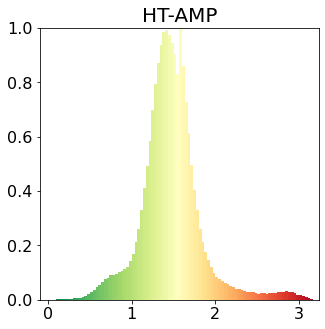

In [0]:
import matplotlib.patches as patches
def plot_distribution_color(ax,this_df,lrange,prop):
    cmap =cm.get_cmap('RdYlGn')   
    if prop=="phi_N01":
        cmap =cm.get_cmap('RdYlGn_r')   
    

    
    ax.set_xlim([lrange[0],lrange[-1]])
    ax.set_ylim([0,1])
    
    this_devs=this_df[prop]
    
    h,n=np.histogram(this_devs,lrange)
    maxh=np.max(h)
    h=[x/maxh for x in h]
    bin_size=n[1]-n[0]
    n=n[1:]-bin_size/2
   
    #print(len(h),len(n))
    
    for ib, b in enumerate(n):
        ax.add_patch(
            patches.Rectangle(
                (b-bin_size/2, 0),   # (x,y)
                bin_size,          # width
                h[ib],          # height
                facecolor=cmap((ib+1)/len(n))
            )
        )
    
    return ax




meanPhiN01=pop_df_plus_limits.phi_N01.mean()
maxPhiN01=pop_df_plus_limits.phi_N01.max()
minPhiN01=pop_df_plus_limits.phi_N01.min()


lrange=np.linspace(0-.1,np.pi+.1,101)




#plt=plot_phi_hist(pop_df_plus['phi_N01'],phi_range,expeLabel)
fig,ax=plt.subplots(figsize=(5,5))
prop='phi_N01'
ax=plot_distribution_color(ax,pop_df_plus,lrange,prop)
plt.title("%s"%(expeLabel))

plt.show()
plt.close()

In [0]:
frames2=[frame_experiment_start,frame_signal_start,int(frame_signal_start+(frame_signal_end-frame_signal_start)/2),frame_signal_end,frame_experiment_end]
frames2=[frame_experiment_start,frame_signal_start,int(frame_signal_start+(frame_signal_end-frame_signal_start)/2),frame_signal_end]
frames2

[55, 91, 109, 127]

DescribeResult(nobs=7655, minmax=(0.13691721792334324, 3.1530251537206513), mean=1.5387759194357136, variance=0.13541374237549303, skewness=1.1029226404548236, kurtosis=4.1707755921404726)
DescribeResult(nobs=7303, minmax=(-0.0522900242031995, 3.0877030288915663), mean=1.472902879226498, variance=0.12365788274741837, skewness=0.7581213954419839, kurtosis=3.2462735016653053)
DescribeResult(nobs=6936, minmax=(-0.015416237905698444, 3.143191649456042), mean=1.3573312262849708, variance=0.11570362406698842, skewness=0.7401693217197385, kurtosis=3.5101938840974958)
DescribeResult(nobs=5254, minmax=(0.25618120205432426, 3.0242332721310716), mean=1.3332504231713678, variance=0.11587111194153794, skewness=0.830514090968564, kurtosis=3.64620715224416)


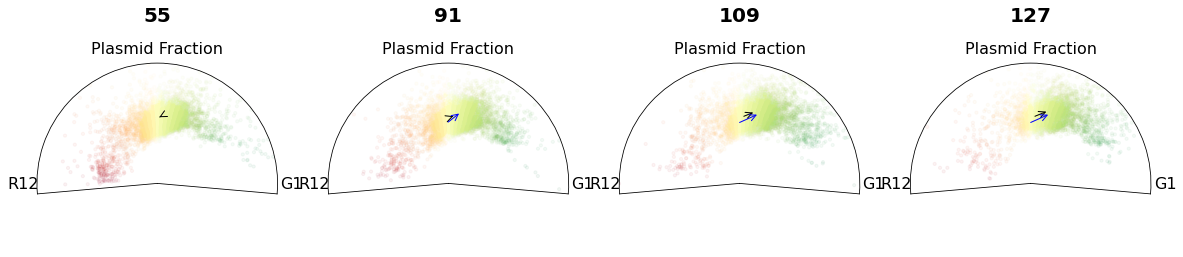

In [0]:

outDir="%sPolar/"%figurePath
if not os.path.exists(outDir):
    os.mkdir(outDir)

def plot_polar_fancy(ax,this_df,ref_df,alph,llim,name,angle_type):
    
    if(angle_type=="phi_N01"):
        rho_type="rho_N01"
    elif(angle_type=="phi_01"):
        rho_type="rho_01"
    ##poopulation data
    phis01=this_df[angle_type]
    rhos01=this_df[rho_type]
    #  meanPhi_Nrot,maxRho_N,meanRho_N  
    colors=cmap([1-x/np.pi for x in phis01])
    ax.scatter(phis01, rhos01,s=10,c=colors,alpha=alph)
    
    this_moments=st.describe(phis01)
    print(this_moments)
    
    
    lphimean=np.mean(phis01)
    lrhomean=np.mean(rhos01)
    
    phisrmode=[round(p,1) for p in phis01]
    rhosrmode=[round(r,1) for r in rhos01]
    p=st.mode(phisrmode)
    r=st.mode(rhosrmode)
    lphimode=p.mode[0]
    lrhomode=r.mode[0]

    
    ####population metrics
    if(ref_df.empty):
    
        ax.scatter(lphimean,lrhomean,s=30,c='k',zorder=3)
        ax.scatter(lphimode,lrhomode,s=30,c='b',zorder=3)

    if(not ref_df.empty):
        phis01=list(ref_df[angle_type])
        rhos01=list(ref_df[rho_type])
        refphimean=np.mean(phis01)
        refrhomean=np.mean(rhos01)
        #ax.scatter(refphimean,refrhomean,s=30,c='k',zorder=3)
        
        ax.annotate("", xy=(lphimean, lrhomean), xytext=(refphimean,refrhomean),  arrowprops=dict(arrowstyle="->",color='k',lw=1))
        
        phisrmode=[round(p,1) for p in phis01]
        rhosrmode=[round(r,1) for r in rhos01]
        p=st.mode(phisrmode)
        r=st.mode(rhosrmode)
        refphimode=p.mode[0]
        refrhomode=r.mode[0]
        #ax.scatter(refphimode,refrhomode,s=30,c='b',zorder=3)
        
        ax.annotate("", xy=(lphimode, lrhomode), xytext=(refphimode,refrhomode),  arrowprops=dict(arrowstyle="->",color='b',lw=1))
        
        
        
    ax.set_rmax(1)
    ax.set_rticks(ticks=[])
    ax.set_thetamin(-llim)
    ax.set_thetamax(180+llim)
    ax.grid(False)
    ax.set_thetagrids([0,90,180],labels=["G1","Plasmid Fraction","R12"])
    #ax.set_title("%s"%(pop), va='bottom')
    ax.set_title(name, va='bottom',fontweight='bold')
    ax.title.set_position([.5, .9])
    return ax
    
fig= plt.figure( figsize=(5*len(frames2), 5))    

ref_df=pd.DataFrame()
ref_df=pop_df_plus[pop_df_plus['frame']<frame_signal_start]
alph=.05
llim=5
Ncolors=50
cmap = cm.get_cmap("RdYlGn", Ncolors)
angle_type="phi_N01"


for ti,t, in enumerate(frames2):
    name="%s"%t
    axist="1%s%s"%(len(frames2),ti+1)
    ax=fig.add_subplot(axist,projection='polar') 
    #filter_t=filterFrames(data_frame, [t])
    this_df=pop_df_plus[pop_df_plus['frame']==t]
    
    plot_polar_fancy(ax,this_df,ref_df,alph,llim,name,angle_type)

#figName=
#plt.savefig()

plt.show()
#print("Saved as %s%s_2Dhist_<pos>_<t>.tif"%(outDir, expeLabel))

[0.0, 0.3141592653589793, 0.6283185307179586, 0.9424777960769379, 1.2566370614359172, 1.5707963267948966, 1.8849555921538759, 2.199114857512855, 2.5132741228718345, 2.827433388230814, 3.141592653589793, 3.2986722862692828]


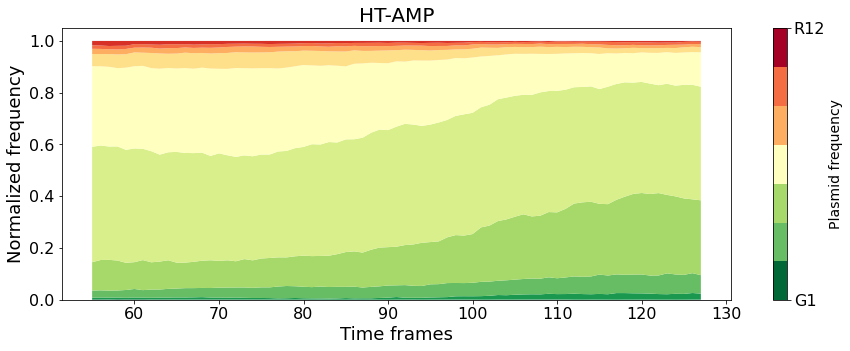

In [0]:
Ncolors=11
cmap = cm.get_cmap("RdYlGn", Ncolors)
cmap_r= cm.get_cmap("RdYlGn_r", Ncolors)


normed=True
bins=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1,1.05]
binsf=[x*np.pi for x in bins]
print(binsf)

times=frames_list
time_freqs=[]
dcolor=[1-x for x in bins]

colorsl=cmap(dcolor)
for ti,t, in enumerate(times):

    this_df=pop_df_plus[pop_df_plus['frame']==t]
    this_data=this_df['phi_N01']
    n,bins,patches=plt.hist(this_data,bins=binsf)#,density='true')
    plt.close()
    tots=sum(n)
    this_freqs=[x for x in n]
    if(normed):
        this_freqs=[x/tots for x in n]
    time_freqs.append(this_freqs)

#time_freqs
#print(time_freqs)
freqs_time=np.zeros((len(time_freqs[0]),len(time_freqs)))

for ti,tfs in enumerate(time_freqs):
    for fi,ft in enumerate(tfs):
        freqs_time[fi][ti]=ft
#print(freqs_time)


#fig= plt.figure( figsize=(10, 5))    
fig,ax=plt.subplots(figsize=(15, 5))
#sc=ax.scatter(binsf,binsf,color=colorsl)
cs = ax.contourf([binsf, bins],cmap=cmap_r)
ax.clear()
ax.stackplot(times,freqs_time,colors=colorsl)
plt.xlabel("Time frames")
plt.ylabel("Normalized frequency")
#plt.colorbar()



cb = plt.colorbar(cs, cmap=cmap)
bcticks=np.linspace(cs.get_array().min(), cs.get_array().max(), 2)
cb.set_ticks(bcticks)
#cb.set_ticklabels(np.linspace(0, round(np.pi,2), 2))
cb.set_ticklabels(["G1","R12"])
cb.set_label('Plasmid frequency',fontsize=14)
#plt.colorbar(sc,ax=ax,ticks=binsf,label="x")
#plt.clim(0, np.pi)
plt.title(expeLabel)

plt.show()

In [0]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')